In [16]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

# Machine learning tooling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import warnings
warnings.filterwarnings("ignore")

# Plot styling
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

RANDOM_STATE = 42
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Comprehensive Spam Email Classification Workflow

This notebook walks through an end-to-end pipeline for building a spam detection model using the classic Spambase word-frequency dataset. We will:

1. Explore and understand the dataset
2. Prepare features and target labels
3. Train multiple baseline classifiers
4. Tune hyperparameters for the best performer
5. Save the optimized model for deployment
6. Demonstrate real-time inference on sample emails

## 1. Load and Inspect the Dataset

The dataset lives at `../data/emails.csv`. We will load it into a pandas DataFrame and perform a quick health check (shape, schema, missing values, and descriptive statistics).

In [17]:
DATA_PATH = "../data/emails.csv"

# Load the dataset
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist()[:10], "...")
print("\nMissing values detected:", df.isnull().sum().any())

# Show basic metadata
print("\nDataset info:")
df.info()

# Display sample rows
display(df.head())

# Basic descriptive statistics
display(df.describe().round(3))

Dataset shape: (5172, 3002)

Columns: ['Email No.', 'the', 'to', 'ect', 'and', 'for', 'of', 'a', 'you', 'hou'] ...

Missing values detected: False

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB


,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
count,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000,...,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000,5172.000
mean,6.641,6.188,5.144,3.076,3.125,2.627,55.517,2.467,2.024,10.600,...,0.005,0.013,0.011,0.098,0.004,0.007,0.004,0.915,0.007,0.290
std,11.745,9.535,14.101,6.046,4.681,6.230,87.574,4.314,6.968,19.282,...,0.106,0.200,0.117,0.570,0.096,0.139,0.072,2.780,0.098,0.454
min,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,1.000,0.000,1.000,0.000,12.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,3.000,3.000,1.000,1.000,2.000,1.000,28.000,1.000,0.000,5.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,8.000,7.000,4.000,3.000,4.000,2.000,62.250,3.000,1.000,12.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000
max,210.000,132.000,344.000,89.000,47.000,77.000,1898.000,70.000,167.000,223.000,...,4.000,7.000,2.000,12.000,3.000,4.000,3.000,114.000,4.000,1.000


## 2. Exploratory Data Analysis (EDA)

We'll examine the target distribution, inspect feature correlations, and visualise a few selected word-frequency columns to understand their behaviour.

Target distribution (%):


Prediction
0    71.0
1    29.0
Name: proportion, dtype: float64

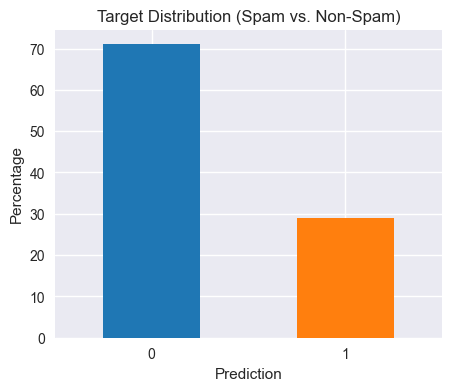

Top 10 features most correlated with spam label:


thanks      -0.271433
hpl         -0.266518
hanks       -0.266070
thank       -0.262384
more         0.258152
attached    -0.236558
daren       -0.236180
forwarded   -0.230765
our          0.228187
subject     -0.227754
dtype: float64

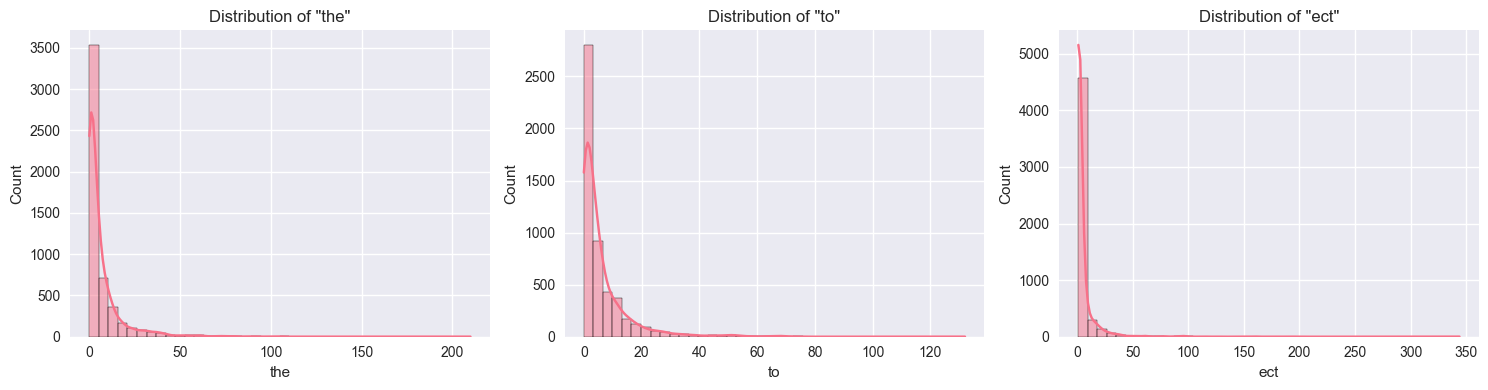

In [18]:
TARGET_COLUMN = 'Prediction'
EMAIL_ID_COLUMN = 'Email No.'

# Separate features from label and drop the identifier column
if EMAIL_ID_COLUMN in df.columns:
    X = df.drop(columns=[TARGET_COLUMN, EMAIL_ID_COLUMN])
else:
    X = df.drop(columns=[TARGET_COLUMN])

y = df[TARGET_COLUMN].astype(int)

print("Target distribution (%):")
class_distribution = y.value_counts(normalize=True).mul(100).round(2)
display(class_distribution)

plt.figure(figsize=(5, 4))
class_distribution.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Target Distribution (Spam vs. Non-Spam)')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

# Correlation analysis
correlations = X.corrwith(y, method='pearson').sort_values(key=np.abs, ascending=False)
print("Top 10 features most correlated with spam label:")
display(correlations.head(10))

# Visualise a few representative features
selected_features = X.columns[:3]
fig, axes = plt.subplots(1, len(selected_features), figsize=(15, 4))
for ax, feature in zip(axes, selected_features):
    sns.histplot(X[feature], kde=True, ax=ax, bins=40)
    ax.set_title(f'Distribution of "{feature}"')
plt.tight_layout()
plt.show()

## 3. Train/Test Split & Feature Scaling

We will perform a stratified split to preserve the spam/non-spam ratio, then scale the features for algorithms that benefit from normalization (SVM, Random Forest). Naive Bayes will use the original word-frequency counts.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

array([[0.        , 0.10495688, 0.06862904, ..., 0.        , 0.        ,
        0.        ],
       [0.17361469, 0.        , 0.13725808, ..., 0.        , 0.33704823,
        0.        ],
       [0.34722938, 0.20991377, 0.06862904, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08680735, 0.6297413 , 0.20588712, ..., 0.        , 0.67409645,
        0.        ],
       [1.47572488, 0.52478441, 0.27451615, ..., 0.        , 0.        ,
        0.        ],
       [1.64933957, 1.25948259, 0.34314519, ..., 0.        , 0.        ,
        0.        ]], shape=(4137, 3000))

## 4. Baseline Model Training & Evaluation

We will benchmark three classic classifiers:

- **Multinomial Naive Bayes** (bag-of-words friendly)
- **Random Forest** (ensemble of decision trees)
- **Support Vector Machine** with RBF kernel

Each model will be evaluated on accuracy, precision, recall, and F1-score using weighted averages to remain robust for class imbalance. We'll also display confusion matrices and classification reports.

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_classification(model, X_tr, y_tr, X_te, y_te, label):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    report = classification_report(
        y_te,
        y_pred,
        target_names=['Non-Spam', 'Spam'],
        output_dict=True
    )

    print(f"\n=== {label} ===")
    print(classification_report(y_te, y_pred, target_names=['Non-Spam', 'Spam']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_te, y_pred))

    return {
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'support': report['weighted avg']['support']
    }

models = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=200),
    'Linear SVM': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE)
}

scores_nb = evaluate_classification(models['Naive Bayes'], X_train, y_train, X_test, y_test, 'MultinomialNB (raw counts)')
scores_rf = evaluate_classification(models['Random Forest'], X_train_scaled, y_train, X_test_scaled, y_test, 'RandomForest (scaled)')
scores_svm = evaluate_classification(models['Linear SVM'], X_train_scaled, y_train, X_test_scaled, y_test, 'Linear SVM (scaled)')


=== MultinomialNB (raw counts) ===
              precision    recall  f1-score   support

    Non-Spam       0.98      0.94      0.96       735
        Spam       0.87      0.94      0.90       300

    accuracy                           0.94      1035
   macro avg       0.92      0.94      0.93      1035
weighted avg       0.94      0.94      0.94      1035

Confusion Matrix:
[[692  43]
 [ 17 283]]

=== RandomForest (scaled) ===
              precision    recall  f1-score   support

    Non-Spam       0.98      0.97      0.98       735
        Spam       0.94      0.95      0.95       300

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035

Confusion Matrix:
[[716  19]
 [ 14 286]]

=== RandomForest (scaled) ===
              precision    recall  f1-score   support

    Non-Spam       0.98      0.97      0.98       735
        Spam       0.94      0.95      0.95       300

  

## 5. Hyperparameter Tuning for the Best Model

We will refine the best-performing baseline model via GridSearchCV using F1-score as the optimisation metric. This step can take a few minutes depending on the grid size.

In [21]:
best_model = models[best_model_name]

if best_model_name == 'Naive Bayes':
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
    }
    estimator = best_model
    X_tr, X_te = X_train, X_test
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [150, 200, 250],
        'max_depth': [None, 20, 40],
        'min_samples_split': [2, 5, 10]
    }
    estimator = best_model
    X_tr, X_te = X_train_scaled, X_test_scaled
else:  # Linear SVM
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced']
    }
    estimator = best_model
    X_tr, X_te = X_train_scaled, X_test_scaled

search = GridSearchCV(estimator, param_grid, cv=5, n_jobs=-1, scoring='f1', verbose=1)
search.fit(X_tr, y_train)

search.best_params_, search.best_score_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


({'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200},
 np.float64(0.9518269429049372))

## 6. Persist the Optimized Pipeline

With the tuned model ready, we'll package the scaler and estimator into a reusable class and persist it to disk for downstream applications (e.g., the Flask app in `src/app.py`).

In [22]:
class SpamClassifierPipeline:
    def __init__(self, scaler, estimator, use_scaler=True):
        self.scaler = scaler if use_scaler else None
        self.estimator = estimator
        self.use_scaler = use_scaler

    def _prepare(self, features: pd.DataFrame):
        if isinstance(features, pd.DataFrame):
            matrix = features.values
        else:
            matrix = features
        if self.scaler is not None and self.use_scaler:
            return self.scaler.transform(matrix)
        return matrix

    def predict(self, features: pd.DataFrame):
        matrix = self._prepare(features)
        return self.estimator.predict(matrix)

    def predict_proba(self, features: pd.DataFrame):
        matrix = self._prepare(features)
        if hasattr(self.estimator, 'predict_proba'):
            return self.estimator.predict_proba(matrix)
        raise AttributeError("The underlying estimator does not support probability estimates.")

use_scaler = best_model_name != 'Naive Bayes'
pipeline = SpamClassifierPipeline(
    scaler=scaler if use_scaler else None,
    estimator=best_model,
    use_scaler=use_scaler
)

pipeline_path = MODELS_DIR / "spam_classifier_pipeline.pkl"
with open(pipeline_path, 'wb') as f:
    pickle.dump(pipeline, f)

print(f"Pipeline saved to {pipeline_path.resolve()}")

# Quick smoke test on a held-out email
sample = X_test.iloc[[0]]
prediction = pipeline.predict(sample)[0]
label_map = {idx: label for idx, label in enumerate(sorted(y.unique()))}
print("Sample prediction:", label_map.get(prediction, prediction))

if use_scaler and hasattr(best_model, 'predict_proba'):
    proba = pipeline.predict_proba(sample)[0]
    if proba.shape[-1] == 2:
        print(f"Probability of spam: {proba[1]:.3f}")

Pipeline saved to E:\My CS\InternShips\Machine Learning - ARCH TECHNOLOGIES - SEP 1 to OCT 31 - Year 2025\Task 1 - Email Spam Classifier\models\spam_classifier_pipeline.pkl
Sample prediction: 0
Probability of spam: 0.110


## 7. Next Steps

- Integrate the saved pipeline with the Flask API in `src/app.py` for real-time inference.
- Track experiments and metrics using MLflow or Weights & Biases for reproducibility.
- Experiment with additional models (e.g., Gradient Boosting, XGBoost) and feature engineering.
- Build a lightweight dashboard to monitor spam detection performance in production.